In [1]:
from utils.video_dataset import VideoFrameDataset
from config.torch_config import get_transform, device, normalize
from config.dataset import get_dataset_path


In [2]:
NUM_SEGMENTS = 2
FRAMES_PER_SEGMENT = 5
BATCH_SIZE = 1
IMAGE_SIZE = 64
NUM_EPOCHS = 20
LEARNING_RATE = 0.001


In [3]:
data_path, model_path = get_dataset_path(dataset="WLASL/videos")
multiple_transform = get_transform(IMAGE_SIZE)


In [4]:
dataset = VideoFrameDataset(
    root_path=data_path,
    transform=multiple_transform,
    num_segments=NUM_SEGMENTS,
    frames_per_segment=FRAMES_PER_SEGMENT,
)

classes = dataset.classes
classes


['0', '1', '2', '3', '4']

In [5]:
from utils.loader import split_dataset


In [24]:
train_loader, test_loader, validation_loader = split_dataset(
    dataset, train_split=0.7, validation_split=0.1, batch_size=BATCH_SIZE
)


In [25]:
print(len(train_loader), len(validation_loader), len(test_loader))


3 0 2


### Example of input of net.

> Initial input = [BATCH_SIZE, NUMBER_OF_FRAMES, CHANNELS, HEIGHT, WIDTH]

This example shows first example (first video) in first batch

In [8]:
from utils.output import plot_tensor
from torchvision.utils import make_grid
from torch import nn


In [9]:
def plot_grid(
    tensor, dims=(1, 2, 0), nrow=FRAMES_PER_SEGMENT*NUM_SEGMENTS, norm=True, start_dim=0, end_dim=1
):
    flat = nn.Flatten(start_dim=start_dim, end_dim=end_dim) # Flatten batch to plot.

    flatted_tensor = flat(tensor)
    grid = make_grid(flatted_tensor.cpu(), nrow=nrow)

    if norm:
        grid = normalize(grid)

    plot_tensor(grid, dims)


### Show input of the net (entire batch)

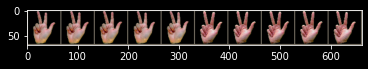

In [10]:
first_batch = next(iter(train_loader))[0]
plot_grid(first_batch)

### The net will then make first and second convolution.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


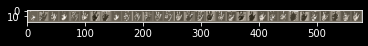

torch.Size([1, 32, 1, 16, 16])

In [11]:
hidden_1, hidden_2 = 16, 32

conv1 = nn.Conv3d(FRAMES_PER_SEGMENT*NUM_SEGMENTS, hidden_1, kernel_size=3, stride=2, padding=1)
conv2 = nn.Conv3d(hidden_1, hidden_2, kernel_size=3, stride=2, padding=1)
relu = nn.LeakyReLU()
batch_1 = nn.BatchNorm3d(hidden_1)
batch_2 = nn.BatchNorm3d(hidden_2)

x = first_batch

x = conv1(x)
x = relu(x)
x = batch_1(x)

x = conv2(x)
x = relu(x)
x = batch_2(x)

plot_grid(x, nrow=hidden_2)

x.shape

## Check balance status of the loaders

In [12]:
# from utils.balance import check_balance_status

# check_balance_status(test_loader, classes)
# check_balance_status(train_loader, classes)


In [13]:
from lib.model import resnet34 as resnet

model = resnet(sample_duration=FRAMES_PER_SEGMENT*NUM_SEGMENTS, sample_size=IMAGE_SIZE, num_classes=len(classes))
model


ResNet(
  (conv1): Conv3d(10, 64, kernel_size=(7, 7, 7), stride=(1, 2, 2), padding=(3, 3, 3), bias=False)
  (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool3d(kernel_size=(3, 3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [14]:
# from lib.simple_model import HPNet

# model = HPNet(
#     num_classes=len(classes),
#     batch_size=BATCH_SIZE,
#     num_frames=FRAMES_PER_SEGMENT * NUM_SEGMENTS,
#     image_size=IMAGE_SIZE,
# )

# model


In [15]:
from lib.train import train_model


In [16]:
train_costs, val_costs = train_model(
    model,
    train_loader,
    validation_loader,
    device,
    learning_rate=LEARNING_RATE,
    num_epochs=NUM_EPOCHS,
)


Training on device: cuda
Train cost at epoch 1 is 2.44465
Validation cost at epoch 1 is 590.34863
Train cost at epoch 2 is 1.81564
Validation cost at epoch 2 is 902.16449
Train cost at epoch 3 is 1.08898
Validation cost at epoch 3 is 499.79358
Train cost at epoch 4 is 0.95873
Validation cost at epoch 4 is 266.79364
Train cost at epoch 5 is 0.97897
Validation cost at epoch 5 is 145.94633
Train cost at epoch 6 is 0.73001
Validation cost at epoch 6 is 71.37521
Train cost at epoch 7 is 0.45399
Validation cost at epoch 7 is 38.51078
Train cost at epoch 8 is 0.35170
Validation cost at epoch 8 is 22.00615
Train cost at epoch 9 is 0.24903
Validation cost at epoch 9 is 14.16585
Train cost at epoch 10 is 0.19202
Validation cost at epoch 10 is 10.00418
Train cost at epoch 11 is 0.14133
Validation cost at epoch 11 is 7.85749
Train cost at epoch 12 is 0.11255
Validation cost at epoch 12 is 6.67632
Train cost at epoch 13 is 0.09263
Validation cost at epoch 13 is 5.94915
Train cost at epoch 14 is 0.0

### Normalize costs between 0 and 1

In [17]:
from utils.output import plot_costs

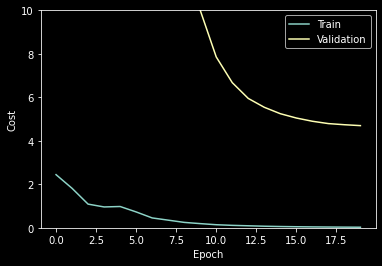

In [18]:
plot_costs(train_costs, val_costs)


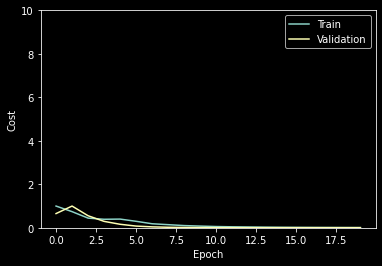

In [19]:
# Normalized costs. Does not represent real cost values.
plot_costs(train_costs, val_costs, normalize_data=True)


In [20]:
from lib.test import check_accuracy


In [21]:
check_accuracy(train_loader, model, classes, device)


Predictions for batch 1 
['2']
Ground truth for batch 1
['2']
---------------------------------


Got 1 / 1 with accuracy 100.00


In [22]:
check_accuracy(test_loader, model, classes, device)

Predictions for batch 1 
['4']
Ground truth for batch 1
['0']
---------------------------------


Got 0 / 1 with accuracy 0.00


In [23]:
check_accuracy(validation_loader, model, classes, device)

Predictions for batch 1 
['2']
Ground truth for batch 1
['1']
---------------------------------


Got 0 / 1 with accuracy 0.00
